# imports

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')
# --------------------------------------------------

# --------------------------------------------------
# load datasets
from sklearn import datasets

# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # pd.get_dummies
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer

# decomposition.PCA
from sklearn.decomposition import PCA


# Classifier ---------------------------------------

# estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression # classifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# --------------------------------------------------

# Regressor-----------------------------------------
# estimators
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostError
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# --------------------------------------------------

# stats : R module
from scipy.stats import skew, kurtosis

# model_selection.splitter
from sklearn.model_selection import train_test_split       # function
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold # cross-validator
from sklearn.model_selection import cross_val_score, cross_validate
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV

# **************************************************

# --------------------------------------------------
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)
 
    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols
# nan_cols = check_nan(df)
# --------------------------------------------------

# --------------------------------------------------
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict
# check_outliers(X_train, 'Insulin')
# --------------------------------------------------

# --------------------------------------------------
def check_object(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
# object_cols = encode(df)
# --------------------------------------------------

# --------------------------------------------------
def mapping(df, col, dict):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df['e_' + col] = df[col].map(dict)
    return df['e_' + col].value_counts()
# mapping(df, 'gender')
# --------------------------------------------------

# --------------------------------------------------
def split_xy(df, target, test_size=0.2):
    
    """split X, y & train, test"""
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')
# --------------------------------------------------

# --------------------------------------------------
def scores(y_test, y_pred):
    
    """evaluation scores"""
    
    f1        = f1_score         (y_test, y_pred, average='macro')
    accuracy  = accuracy_score   (y_test, y_pred, )
    precision = precision_score  (y_test, y_pred, average='macro')
    recall    = recall_score     (y_test, y_pred, average='macro')
    c_matrix  = confusion_matrix (y_test, y_pred, )
    
    print(
          f'accuracy  = {accuracy:.6f},  '
          f'f1 score  = {f1:.6f},  \n'
          f'precision = {precision:.6f},  '
          f'recall    = {recall:.6f},')
    print(c_matrix)
    
    # plt.figure(figsize=(12, 9))
    # plt.title('confusion matrix')
    # plt.xlabel('Predict')
    # plt.ylabel('Actual')
    # sns.heatmap(c_matrix, annot=True, linewidths=1, cmap='Blues', annot_kws={"size": 14})
    # plt.show()
# --------------------------------------------------

# --------------------------------------------------
def curves(y_test, probas_pred):
        
    FPRS, TPRS, thresholds = roc_curve(y_test, probas_pred[:, 1])
 
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
 
    # settings
    plt.subplot(121)
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')
 
    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')
    plt.legend()
 
    precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
 
    plt.subplot(122)
    plt.title('precision recall curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('scores')
 
    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.legend()
 
    plt.show()
    
    print('AUC = ', roc_auc_score(y_test, probas_pred[:, 1]))
# --------------------------------------------------
# --------------------------------------------------

# read shipping

In [2]:
df = pd.read_csv('./kaggle/shipping/shipping.csv')
df.shape

(10999, 12)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [4]:
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# shipping df ver00

## encode

In [5]:
df['Mode_of_Shipment'].value_counts()

Ship      7462
Flight    1777
Road      1760
Name: Mode_of_Shipment, dtype: int64

In [6]:
df['Warehouse_block'].value_counts()

F    3666
D    1834
A    1833
B    1833
C    1833
Name: Warehouse_block, dtype: int64

In [7]:
df['Product_importance'].value_counts()

low       5297
medium    4754
high       948
Name: Product_importance, dtype: int64

In [8]:
df['Gender'].value_counts()

F    5545
M    5454
Name: Gender, dtype: int64

In [9]:
# Warehouse_block
wb_dict = {'A':0, 'B':1, 'C':2, 'D':3, 'F':4}
df['Warehouse_block'] = df['Warehouse_block'].map(wb_dict)
df['Warehouse_block'].value_counts()

4    3666
3    1834
0    1833
1    1833
2    1833
Name: Warehouse_block, dtype: int64

In [10]:
# Product_importance
pi_dict = {'low':0, 'medium':1, 'high':2}
df['Product_importance'] = df['Product_importance'].map(pi_dict)
df['Product_importance'].value_counts()

0    5297
1    4754
2     948
Name: Product_importance, dtype: int64

In [11]:
# Mode_of_Shipment, Gender
oe = OrdinalEncoder()
df[['Mode_of_Shipment', 'Gender']] = oe.fit_transform(df[['Mode_of_Shipment', 'Gender']])
df[['Mode_of_Shipment', 'Gender']].head(10)

,Mode_of_Shipment,Gender
0,0.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10999 non-null  int64  
 1   Warehouse_block      10999 non-null  int64  
 2   Mode_of_Shipment     10999 non-null  float64
 3   Customer_care_calls  10999 non-null  int64  
 4   Customer_rating      10999 non-null  int64  
 5   Cost_of_the_Product  10999 non-null  int64  
 6   Prior_purchases      10999 non-null  int64  
 7   Product_importance   10999 non-null  int64  
 8   Gender               10999 non-null  float64
 9   Discount_offered     10999 non-null  int64  
 10  Weight_in_gms        10999 non-null  int64  
 11  Reached.on.Time_Y.N  10999 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1.0 MB


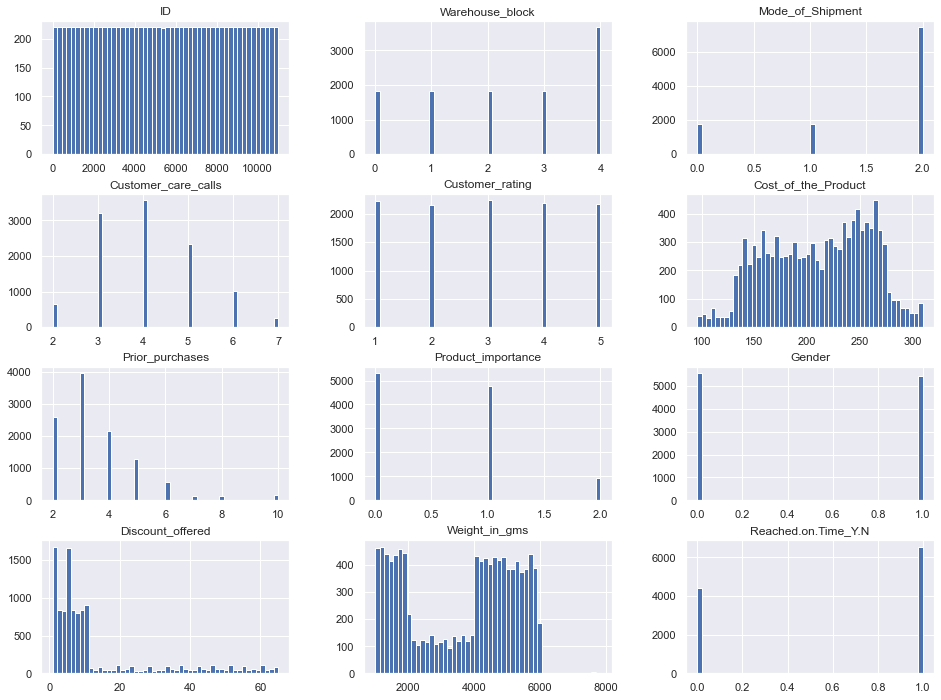

In [13]:
df.hist(figsize=(16, 12), bins=50); plt.show()

## scale

# statistics

In [14]:
# 중심경향값   : 평균, 중앙값, 최빈값
# 산포도(퍼짐) : 표준편차, 분산, 범위, 사분위수
# 분포도(모양) : skew, kurtosis

# 정규분포 : 평균을 중심으로 좌우대칭 형태
# 중심극한 : 중심극한의 정리(CLT, Central Limit Theorem)
#           표본의 평균은 표본의 개수(n)가 커질수록, 정규분포와 유사해진다.
#           표본의 수가 충분히 크다면, 정규분포라고 가정할 수 있다.(n > 30)

# np.power  : 제곱(**)
# np.sqrt   : 제곱근

In [15]:
# 평균 np.mean() : sample sum / sample count
list = [1, 2, 3, 4, 5]
평균 = np.mean(list); 평균

3.0

In [16]:
# 편차 : sample - mean
dev_list = []
for i in list:
    dev_list.append(평균-i)    
dev_list

[2.0, 1.0, 0.0, -1.0, -2.0]

In [17]:
# 분산 np.var() : dev^2 mean
분산 = np.square(dev_list).mean(); 분산

2.0

In [18]:
np.var(list)

2.0

In [19]:
# 표준편차 np.std() : var 제곱근
np.sqrt(분산)

1.4142135623730951

In [20]:
np.std(list)

1.4142135623730951

# regression

## read boston

In [21]:
# https://www.kaggle.com/vikrishnan/boston-house-prices?
boston = datasets.load_boston()
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df['target'] = boston['target']

# feature description
# crim	  자치시(town)별 1인당 범죄율
# zn	  25,000 평방 피트를 초과하는 거주지역의 비율
# indus	  비소매상업지역이 차지하고 있는 토지의 비율
# chas	  찰스강의 경계에 위치한 경우는 1, 아니면 0
# nox	  10ppm 당 농축 일산화질소
# rm	  주택 1가구당 평균 방의 수
# age	  1940년 이전에 건축한 소유주택 비율
# dis	  보스톤 직업센터까지의 접근성 지수
# rad	  방사형 도로까지의 접근성 지수
# tax	  10,000 달러당 재산세율
# ptratio 자치시(town)별 학생/교사 비율
# b       자치시(town)별 흑인의 비율
# lstat	  모집단의 하위 계층의 비율
# medv	  본인 소유의 주택가격 중앙값(단위 $1000)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


## outlier

### IQR

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcAqc6V%2FbtqyQLiddUd%2FiXQVu1nYTo2rx3Q8xZBqy0%2Fimg.png" width=800 height=300>

In [23]:
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict

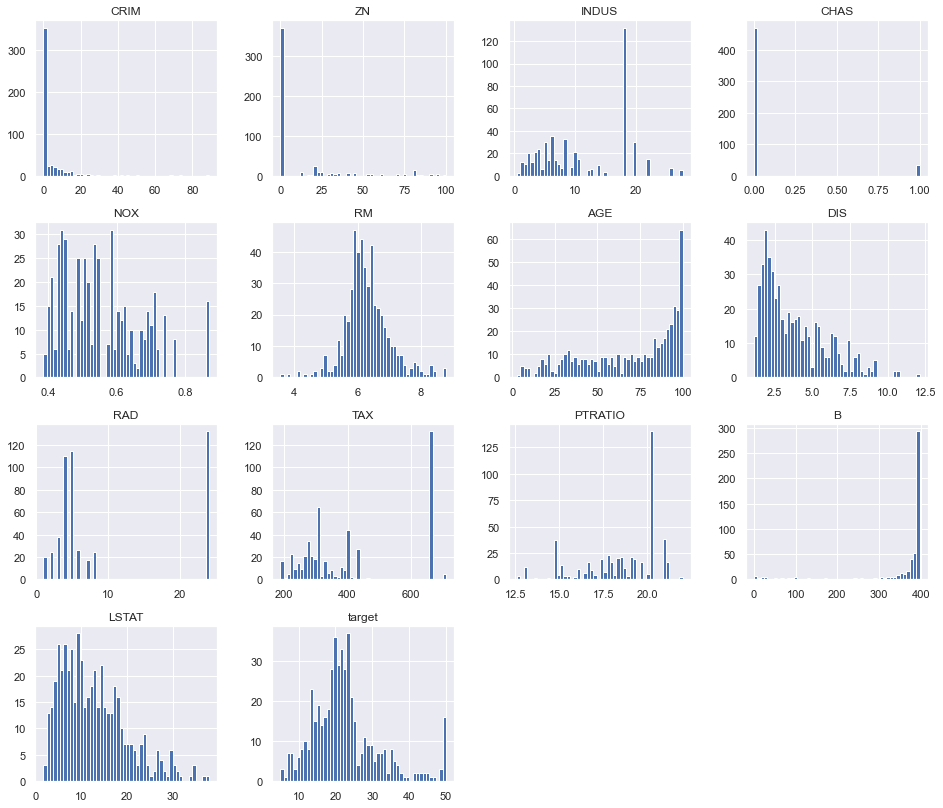

In [24]:
df.hist(figsize=(16, 14), bins=50); plt.show()

In [25]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


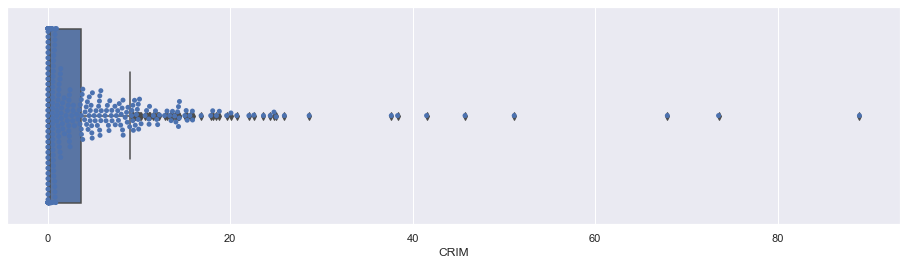

In [26]:
# CRIM : 60 이상
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(df['CRIM'])
sns.swarmplot(x=df['CRIM'])
plt.show()

In [27]:
df.shape

(506, 14)

In [28]:
crim_dropidx = df[df['CRIM'] >= 60].index.values ; crim_dropidx

array([380, 405, 418], dtype=int64)

In [29]:
df = df.drop(crim_dropidx)
df.shape

(503, 14)

In [30]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [31]:
df = df.reset_index()

### met : drop crim ol

In [32]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [33]:
X_train_log = np.log1p(X_train)
X_test_log  = np.log1p(X_test)
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

In [34]:
scale = StandardScaler()

scale.fit(X_train_log)
X_train_sc = pd.DataFrame(scale.transform(X_train_log))
X_test_sc  = pd.DataFrame(scale.transform(X_test_log))

scale.fit(np.array(y_train_log).reshape(-1, 1))
y_train_sc = pd.DataFrame(scale.transform(np.array(y_train_log).reshape(-1, 1)))
y_test_sc  = pd.DataFrame(scale.transform(np.array(y_test_log).reshape(-1, 1)))

In [35]:
# ------------------------------
X_train = X_train_sc
X_test  = X_test_sc
y_train = y_train_sc
y_test  = y_test_sc
# ------------------------------

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          DecisionTreeRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          ]

for model in models:
    print(model.__class__.__name__)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MSE  =', mse)
    print('RMES =', rmse)
    print('-' * 30)

LinearRegression
MSE  = 0.20294421108159721
RMES = 0.45049329748798395
------------------------------
Ridge
MSE  = 0.20323732148757767
RMES = 0.4508185017139133
------------------------------
Lasso
MSE  = 0.8994908219212231
RMES = 0.948414899672724
------------------------------
ElasticNet
MSE  = 0.6180119124066462
RMES = 0.7861373368608352
------------------------------
DecisionTreeRegressor
MSE  = 0.3108113629543446
RMES = 0.5575045855904188
------------------------------
XGBRegressor
MSE  = 0.142804505813191
RMES = 0.37789483432985826
------------------------------
LGBMRegressor
MSE  = 0.12939155732379357
RMES = 0.35971037978322723
------------------------------


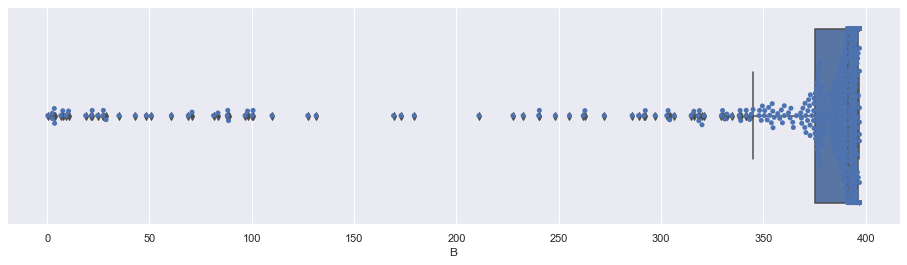

In [36]:
# B
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxplot(df['B'])
sns.swarmplot(x=df['B'])
plt.show()

In [37]:
b_dropidx = df[df['B'] < 150].index.values ; b_dropidx

array([102, 155, 156, 367, 408, 409, 410, 412, 413, 414, 415, 416, 420,
       421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
       434, 435, 442, 447, 451, 452, 453, 454, 463], dtype=int64)

In [38]:
df = df.drop(b_dropidx)
df.shape

(468, 15)

In [39]:
df.head()

,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [40]:
df = df.reset_index(drop=True)

In [76]:
df.head()

,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [77]:
df = df.drop('index', axis=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### met : drop crim, b ol

In [42]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [43]:
X_train_log = np.log1p(X_train)
X_test_log  = np.log1p(X_test)
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

In [44]:
scale = StandardScaler()

scale.fit(X_train_log)
X_train_sc = pd.DataFrame(scale.transform(X_train_log))
X_test_sc  = pd.DataFrame(scale.transform(X_test_log))

scale.fit(np.array(y_train_log).reshape(-1, 1))
y_train_sc = pd.DataFrame(scale.transform(np.array(y_train_log).reshape(-1, 1)))
y_test_sc  = pd.DataFrame(scale.transform(np.array(y_test_log).reshape(-1, 1)))

In [45]:
# ------------------------------
X_train = X_train_sc
X_test  = X_test_sc
y_train = y_train_sc
y_test  = y_test_sc
# ------------------------------

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          DecisionTreeRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          ]

for model in models:
    print(model.__class__.__name__)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MSE  =', mse)
    print('RMES =', rmse)
    print('-' * 30)

LinearRegression
MSE  = 0.31656285551794494
RMES = 0.5626391876842075
------------------------------
Ridge
MSE  = 0.31670929355983646
RMES = 0.5627693075851209
------------------------------
Lasso
MSE  = 1.0264616797002442
RMES = 1.013144451546888
------------------------------
ElasticNet
MSE  = 0.7110374673658583
RMES = 0.8432303762115417
------------------------------
DecisionTreeRegressor
MSE  = 0.32070010232037266
RMES = 0.5663038957312343
------------------------------
XGBRegressor
MSE  = 0.22769670227139552
RMES = 0.47717575616474434
------------------------------
LGBMRegressor
MSE  = 0.2278453078541891
RMES = 0.47733144444315534
------------------------------


## X, y split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

## log + Xy scale

In [47]:
X_train_log = np.log1p(X_train)
X_test_log  = np.log1p(X_test)
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

In [78]:
scale = StandardScaler()

scale.fit(X_train_log)
X_train_sc = pd.DataFrame(scale.transform(X_train_log), columns=df.columns)
X_test_sc  = pd.DataFrame(scale.transform(X_test_log), columns=df.columns)

scale.fit(np.array(y_train_log).reshape(-1, 1))
y_train_sc = pd.DataFrame(scale.transform(np.array(y_train_log).reshape(-1, 1)))
y_test_sc  = pd.DataFrame(scale.transform(np.array(y_test_log).reshape(-1, 1)))

In [49]:
# ------------------------------
X_train = X_train_sc
X_test  = X_test_sc
y_train = y_train_sc
y_test  = y_test_sc
# ------------------------------

models = [LinearRegression(),
          Ridge(),
          Lasso(),
          ElasticNet(),
          DecisionTreeRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          ]

for model in models:
    print(model.__class__.__name__)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print('MSE  =', mse)
    print('RMES =', rmse)
    print('-' * 30)

LinearRegression
MSE  = 0.31656285551794494
RMES = 0.5626391876842075
------------------------------
Ridge
MSE  = 0.31670929355983646
RMES = 0.5627693075851209
------------------------------
Lasso
MSE  = 1.0264616797002442
RMES = 1.013144451546888
------------------------------
ElasticNet
MSE  = 0.7110374673658583
RMES = 0.8432303762115417
------------------------------
DecisionTreeRegressor
MSE  = 0.31318889982661957
RMES = 0.5596328259016081
------------------------------
XGBRegressor
MSE  = 0.22769670227139552
RMES = 0.47717575616474434
------------------------------
LGBMRegressor
MSE  = 0.2278453078541891
RMES = 0.47733144444315534
------------------------------


## cross validation

In [70]:
# 연속형 데이터는 골고루 등분할 수 없기 때문에, SKFold 사용 불가
# cross_val, gridsearchcv

In [79]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [92]:
X.shape, y.shape

((468, 13), (468, 1))

In [84]:
X.columns = df.columns
X = X.drop('target', axis=1)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.002170,-0.662670,-0.61339,-0.964672,-0.278944,-0.297040,-0.576375,0.261157,-0.482934,-0.251763,-0.483560,-0.701432,0.359479
1,0.512101,-0.710665,1.84191,-0.622143,-0.278944,-1.322984,-0.072788,-0.993577,1.536100,-0.031848,-0.510050,-0.701432,0.455832
2,-0.560467,-0.598651,-0.61339,0.009791,-0.278944,-0.203080,0.629343,0.504252,-0.432312,-0.251763,0.193567,1.094041,0.399757
3,0.188794,-0.350322,-0.61339,0.303802,3.584948,-0.496398,-1.366150,0.866262,0.203664,-0.511868,-0.656060,0.182643,0.455832
4,0.760223,0.969186,-0.61339,1.066556,-0.278944,1.539994,-1.992851,0.721081,-1.222250,1.784197,1.627468,0.827207,-1.906706


In [90]:
y.head()

,0
0,0.099055
1,0.168941
2,0.624207
3,-0.225862
4,0.015241


In [91]:
y.shape

(468, 1)

### kfold

In [104]:
model = XGBRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=0)

total_mse  = []
total_rmse = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    total_mse.append(mse)
    total_rmse.append(rmse)

print(np.mean(total_mse))
print(np.mean(total_rmse))

0.2260137625387829
0.4565253708876339


## cross_val_score

In [161]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
xgbr = XGBRegressor(n_estimators=6, learning_rate=1)

def error_score(estimator, y_test, y_pred):
    y_pred = estimator.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return mse, rmse

cv_results = cross_val_score(xgbr, X, y, scoring='neg_root_mean_squared_error', cv=kfold)

In [162]:
-cv_results.mean()

0.5927712965286125

## cross_validate

In [180]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
xgbr = XGBRegressor(n_estimators=6, learning_rate=1)

cv_dict = {'MSE':'neg_mean_squared_error',
           'RMSE':'neg_root_mean_squared_error'
           }

cv_results = cross_validate(xgbr, X, y, scoring=cv_dict, cv=kfold)

In [181]:
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_MSE', 'test_RMSE'])

In [185]:
- cv_results['test_MSE'].mean()

0.3738960838235734

In [186]:
- cv_results['test_RMSE'].mean()

0.5927712965286125

## GridSearchCV

In [204]:
model = XGBRegressor()
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# hyper_param = {'n_estimators':[100],
            #    'learning_rate':[0.1, 0.2, 0.3],
            #    }

cv_dict = {'MSE':'neg_mean_squared_error',
           'RMSE':'neg_root_mean_squared_error'
           }

gscv = GridSearchCV(model, param_grid=hyper_param, scoring=cv_dict, 
                    refit='RMSE', cv=kfold, return_train_score=True)

gscv.fit(X, y)
-gscv.best_score_

0.4565253708876339

In [205]:
gscv.best_params_

{'n_estimators': 100}

In [206]:
print(dir(gscv))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_check_is_fitted', '_check_n_features', '_check_refit_for_multimetric', '_estimator_type', '_format_results', '_get_param_names', '_get_tags', '_more_tags', '_pairwise', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_run_search', '_validate_data', 'best_estimator_', 'best_index_', 'best_params_', 'best_score_', 'classes_', 'cv', 'cv_results_', 'decision_function', 'error_score', 'estimator', 'fit', 'get_params', 'inverse_transform', 'multimetric_', 'n_features_in_', 'n_jobs', 'n_splits_', 'param_grid', 'pre_dispatch', 'predict', 'predict_log_pro

In [60]:
a = pd.DataFrame({'ro':[1, 2, 3, 4, 5], 'po':[3, 6, 9, 12, 15]})
a

,ro,po
0,1,3
1,2,6
2,3,9
3,4,12
4,5,15


In [61]:
a = a.drop(index=2)
a

,ro,po
0,1,3
1,2,6
3,4,12
4,5,15


In [62]:
a = a.reset_index(drop=True); a

,ro,po
0,1,3
1,2,6
2,4,12
3,5,15


In [176]:
np.where(a.columns.values == 'po')[0][0]

1

In [167]:
c = np.where(df.columns == 'B')

In [173]:
print(c[0][0]) 

11
